# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
#from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [5]:
def CombineFieldResults(CatName,wavelength): # #Name options- 'CombCat', 'SegCat', 'DaoCat'
    #pick a field to start with so we can get the table structure. 
    #The files for the field cannot be empty or an error message will display
    startfield=Field01.name

    if os.path.exists(startfield+'_'+str(wavelength)+'um_'+CatName+'.fits'):
        cat=Table.read(startfield+'_'+str(wavelength)+'um_'+CatName+'.fits')

        #fix for issue with combining tables with objects as columns
        cat['RA(J2000)']=cat['sky_centroid'].ra
        cat['DEC(J2000)']=cat['sky_centroid'].dec
        cat['glon']=cat['sky_centroid'].galactic.l.deg
        cat['glat']=cat['sky_centroid'].galactic.b.deg
        cat.remove_column('sky_centroid')

    else:
        print('Error... Must pick another file to start with')
        
        
    #loop through all the saved photometry tables for individual fields and append them together
    for info in field._registry:
        filename=info.filename
        name=info.name

        #print('\nLoading in photometry data from field: ', name)

        if name is not startfield:

            if os.path.exists(name+'_'+str(wavelength)+'um_'+CatName+'.fits'):
                newtab1=Table.read(name+'_'+str(wavelength)+'um_'+CatName+'.fits')

                #fix for issue with combining tables with objects as columns
                newtab1['RA(J2000)']=newtab1['sky_centroid'].ra
                newtab1['DEC(J2000)']=newtab1['sky_centroid'].dec
                newtab1['glon']=newtab1['sky_centroid'].galactic.l.deg
                newtab1['glat']=newtab1['sky_centroid'].galactic.b.deg
                newtab1.remove_column('sky_centroid')

                #combine tables
                cat=vstack([cat,newtab1])


    #print the table sizes to get source counts
    #print('Raw number of combinded sources: ', len(cat))
    
    #sort table entries by gal. lat. 
    cat.sort('glon')
    
    #fix to wrap galactic coordinates
    alttabidx2=cat['glon']>180
    alttabidx1=cat['glon']<180
    c1=cat[alttabidx2]
    c2=cat[alttabidx1]
    catnew=vstack([c1,c2])
    
    #rename field based id to anothter name to avoid confusion
    #catnew.rename_column('id', 'old_id')
    
    #remove original source 'id' values because they are field based and not useful in combined table
    catnew.remove_column('id')

    #add new ids to the master catalog
    catnew['id']=np.linspace(1,len(catnew),len(catnew),dtype=np.int64)
    
    #re-add "sky_centroid" column 
    catnew['sky_centroid']=SkyCoord(catnew['RA(J2000)'],catnew['DEC(J2000)'],unit=u.deg)

    #return combined catalog
    return catnew
    

In [6]:
#source coords should be skycoord objects, sep should be an angular quantity e.g., 4*u.arcsec
def remove_duplicates(cat, sep):
	sourcecoords=cat['sky_centroid']

	#create KD Tree
	kdt=_get_cartesian_kdtree(sourcecoords)
    
	#search radius
	r = (2 * np.sin(Angle(sep) / 2.0)).value #search radius
    
	#initialize counter
	counter=0
    
	#create array to hold matches
	matchstore=np.zeros(len(cat),dtype=np.int64)
    
	#loop through and find all matching sources within crossmatch radius
	for i, matches in enumerate(kdt.query_ball_tree(kdt,r)):
		if len(matches)>1:
			counter+=1
			
			for match in matches:
				if match!=matches[(match+1)%len(matches)]:
					matchstore[match]=matches[(match+1)%len(matches)]+1
				else:
					matchstore[match]=matches[(match+2)%len(matches)]+1

	#store possible crossmatches
	cat['selfXmatch']=matchstore
	print('number of likely duplicates: ', counter)
    
	#create keep and remove lists
	keep=[]
	remove=[]
    
	#loop through and mark sources to keep and remove based on which has the greater aperture photometry snr
	for row in cat:
		if row['selfXmatch']>0:
			#print(row['Master_id'])
			idx1 = row['id']
			idx2 = row['selfXmatch']
			
			row1=cat[cat['id']==idx1]
			row2=cat[cat['id']==idx2]
			
			snr1=row1['aper_snr_4pix'].data[0]
			snr2=row2['aper_snr_4pix'].data[0]
			           
			if snr1>snr2:
				keep.append(idx1)
				remove.append(idx2)
			else:
				keep.append(idx2)
				remove.append(idx1)

	#remove duplicates in lists
	keep=list(set(keep))
	remove=list(set(remove))
    
	#remove duplicates in table
	removeIdx=np.array(remove)-1 #fix zero/one initialization issue
	cat.remove_rows(removeIdx)
	
	return cat

In [7]:
def makeDS9file(savename, table, radius, color='green', labelon=False,label='ColumnName'):
    scs=table['sky_centroid']
    
    decimals = 1 # number of decimal places to display with labels
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
            #write out region file
    write_ds9(regions, savename)
    
    
    hld=""
    with open(savename, 'r+') as f:
        lineno=0
        for line in f:
            if lineno<=(len(table)+1):
                if labelon:
                    text=line.replace(r')', r') # color='+color+' text={'+str(np.round(table[label][lineno-2],decimals))+'}')
                else:
                    text=line.replace(r')', r') # color='+color)
                hld=hld+text
                lineno=lineno+1
        f.seek(0)
        f.write(hld)
        f.truncate()

In [8]:
#find the 'not' indcies for sources in table
def findNOTindex(tab,index):
    allpos=np.linspace(0,len(tab)-1,len(tab),dtype=np.int64) 
    notindex=list(set(allpos)-set(index))
    return notindex

In [9]:
#create catalog names for sources based on galactic coords
def createNames(tab):
    #get lat and long values
    latvals=tab['glat'].value
    lonvals=tab['glon'].value
    #convert to strings
    strings1 = ["%.4f" % lonvals for lonvals in lonvals]
    strings2 = ["%.4f" % latvals for latvals in latvals]
    #update string 2 to include '+' signs where needed
    s2update=[]
    for string in strings2:
        if not string.startswith('-'):
            string='+'+string
        s2update.append(string)
    #create names array
    names=['SFGC'+strings1+s2update for strings1,s2update in zip(strings1,s2update)]
    #add names to table
    tab['SourceID']=names
    #return table with names added
    return tab

## Combine data files for each field at 25 um

In [10]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#add names to mastercat
mastercat25=createNames(mastercat25)

#print the master catalog
mastercat25

type,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_4.25pix,aperture_sum_err_4.25pix,aperture_sum_4.5pix,aperture_sum_err_4.5pix,aperture_sum_4.75pix,aperture_sum_err_4.75pix,aperture_sum_5.0pix,aperture_sum_err_5.0pix,aperture_sum_5.25pix,aperture_sum_err_5.25pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_4.25pix,aper_snr_4.25pix,aper_area_4.25pix,aper_sum_bkgsub_4.5pix,aper_snr_4.5pix,aper_area_4.5pix,aper_sum_bkgsub_4.75pix,aper_snr_4.75pix,aper_area_4.75pix,aper_sum_bkgsub_5.0pix,aper_snr_5.0pix,aper_area_5.0pix,aper_sum_bkgsub_5.25pix,aper_snr_5.25pix,aper_area_5.25pix,aper_sum_bkgsub_5.5pix,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19
10,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4236458480866823,0.10047859269606844,1.5466724294218617,0.10682069261019145,1.6750884713269265,0.11316535920513267,1.811050718384554,0.11953170198323691,1.9531973783819776,0.1259296609481708,2.1006656962556454,0.13241835165576693,2.2508335266315496,0.13897037508002757,3.8682682544679565,0.20602930127861335,4.96666312214726,0.259997705122562,5.481791418260418,0.31385377241813783,842.3886568673647,-0.0004654688610713117,-0.0012500817765666544,0.009320970097764732,262.2360534667969,205.75838464830025,1.4481524536298975,17.15805958065859,52.649291054210295,1.5743380895858818,18.902379349781103,59.4361137291671,1.7061046439675582,20.75629293688845,66.6342589904849,1.8456088613576036,22.761832113490314,74.24372683816375,1.9914889495432515,24.89419663722413,82.26451727220358,2.14288215346095,27.13750399429203,90.69663029260447,2.297166327736691,29.44128686435674,99.54006589936637,3.9662946766408176,55.11135086679856,210.59716421684118,5.1198294067923555,72.10873074592747,329.0580690888143,5.702350868149355,77.77123090967218,473.84361948789274,Field49,25,6.7456997274677555,7.975597084552329,6.581135564871462,3.2529737500683717,2.24486693578359,-81.07403059593263,1.449071968683477,5.172855864516933,10.448409913491359,1.4959128022772794,-0.024519865598240723 .. 0.004305923092190833,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.3464-0.0829
10,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.914611742490516,0.08565943133769197,2.09599303701002,0.09125818516820391,2.2658869049688377,0.09690035335625888,2.4363750292144504,0.10257197890324246,2.6099130502012837,0.10832554482748215,2.7856322410183307,0.11412600802904477,2.9671053266403287,0.11993951266956053,4.671164651453947,0.17996353882181432,5.704260940850375,0.23076074345128952,6.49623154377986,

In [11]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [12]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(2.778E-4*3, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', labelon=True, label="id")
makeDS9file('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [13]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25=remove_duplicates(mastercat25, 5.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1024
number of likely duplicates:  383
Number of sources with duplicates removed:  813


In [14]:
#write 'master' catalogs to fits - optional for testing
#mastercat25.write('masterCat_FromFields_noDuplicates_25um.fits',overwrite=True)

In [15]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', labelon=True, label="id")

In [16]:
mastercat25

type,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_4.25pix,aperture_sum_err_4.25pix,aperture_sum_4.5pix,aperture_sum_err_4.5pix,aperture_sum_4.75pix,aperture_sum_err_4.75pix,aperture_sum_5.0pix,aperture_sum_err_5.0pix,aperture_sum_5.25pix,aperture_sum_err_5.25pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_4.25pix,aper_snr_4.25pix,aper_area_4.25pix,aper_sum_bkgsub_4.5pix,aper_snr_4.5pix,aper_area_4.5pix,aper_sum_bkgsub_4.75pix,aper_snr_4.75pix,aper_area_4.75pix,aper_sum_bkgsub_5.0pix,aper_snr_5.0pix,aper_area_5.0pix,aper_sum_bkgsub_5.25pix,aper_snr_5.25pix,aper_area_5.25pix,aper_sum_bkgsub_5.5pix,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19,int64
10,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4236458480866823,0.10047859269606844,1.5466724294218617,0.10682069261019145,1.6750884713269265,0.11316535920513267,1.811050718384554,0.11953170198323691,1.9531973783819776,0.1259296609481708,2.1006656962556454,0.13241835165576693,2.2508335266315496,0.13897037508002757,3.8682682544679565,0.20602930127861335,4.96666312214726,0.259997705122562,5.481791418260418,0.31385377241813783,842.3886568673647,-0.0004654688610713117,-0.0012500817765666544,0.009320970097764732,262.2360534667969,205.75838464830025,1.4481524536298975,17.15805958065859,52.649291054210295,1.5743380895858818,18.902379349781103,59.4361137291671,1.7061046439675582,20.75629293688845,66.6342589904849,1.8456088613576036,22.761832113490314,74.24372683816375,1.9914889495432515,24.89419663722413,82.26451727220358,2.14288215346095,27.13750399429203,90.69663029260447,2.297166327736691,29.44128686435674,99.54006589936637,3.9662946766408176,55.11135086679856,210.59716421684118,5.1198294067923555,72.10873074592747,329.0580690888143,5.702350868149355,77.77123090967218,473.84361948789274,Field49,25,6.7456997274677555,7.975597084552329,6.581135564871462,3.2529737500683717,2.24486693578359,-81.07403059593263,1.449071968683477,5.172855864516933,10.448409913491359,1.4959128022772794,-0.024519865598240723 .. 0.004305923092190833,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.3464-0.0829,0
10,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.914611742490516,0.08565943133769197,2.09599303701002,0.09125818516820391,2.2658869049688377,0.09690035335625888,2.4363750292144504,0.10257197890324246,2.6099130502012837,0.10832554482748215,2.7856322410183307,0.11412600802904477,2.9671053266403287,0.11993951266956053,4.671164651453947,0.17996353882181432,5.704260940850375,0.230760743451289

### Quality flags and other cuts

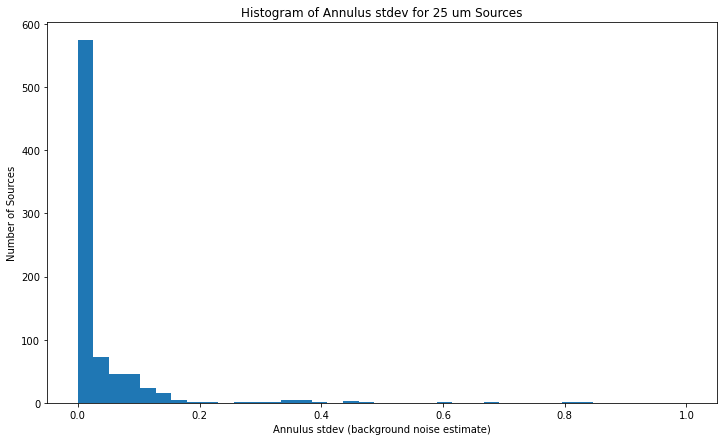

In [17]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 25 um Sources')
plt.hist(mastercat25['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [18]:
#add quality flags for background noise
bkgmean=np.mean(mastercat25['ann_bkg_std'])
bkgstd=np.std(mastercat25['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat25['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat25['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat25['ann_bkg_std']>bkgmean+3*bkgstd


mastercat25['bkg_qflag']=0
mastercat25['bkg_qflag'][bkgstd1sig]=1
mastercat25['bkg_qflag'][bkgstd2sig]=2
mastercat25['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.04526062709076076 , standard deviation of noise measurements:  0.1253009781777376


In [19]:
print('Central distance fit mean: ', np.mean(mastercat25['fit_dist']), '  stdev: ',np.std(mastercat25['fit_dist']))

Central distance fit mean:  1.6000772559896546   stdev:  1.2448326144139212


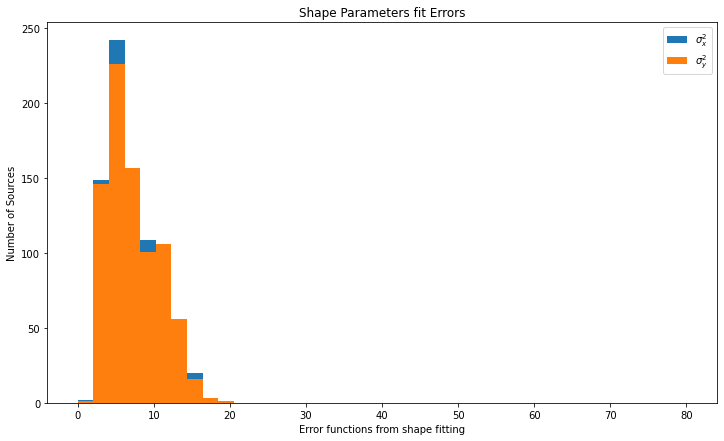

In [20]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat25['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mastercat25['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [21]:
print('Covar X^2 mean: ', np.mean(mastercat25['covar_sigx2']), '  stdev: ',np.std(mastercat25['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mastercat25['covar_sigy2']), '  stdev: ',np.std(mastercat25['covar_sigy2']))

Covar X^2 mean:  7.1735626947637465   stdev:  3.3319533504927885
Covar Y^2 mean:  7.275579815103961   stdev:  3.303047552114918


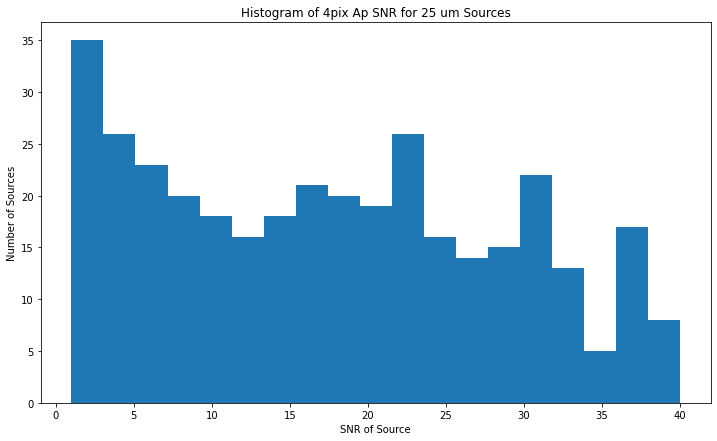

In [22]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [23]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=3.0 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  592


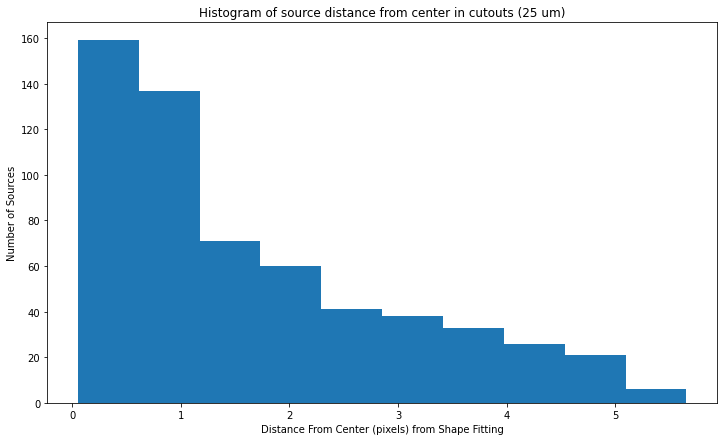

In [24]:
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (25 um)')
plt.hist(mcat25snrcut['fit_dist'])#,bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [25]:
print('Central distance fit mean: ', np.mean(mcat25snrcut['fit_dist']), '  stdev: ',np.std(mcat25snrcut['fit_dist']))

Central distance fit mean:  1.6619438648542308   stdev:  1.3526938166599964


In [26]:
#apply quality flags to table
Distmean=np.mean(mcat25snrcut['fit_dist'])
Diststd=np.std(mcat25snrcut['fit_dist'])

distidx1=mcat25snrcut['fit_dist']>4.0
distidx2=mcat25snrcut['fit_dist']>7.0

mcat25snrcut['shape_qflag']=0

mcat25snrcut['shape_qflag'][distidx1]=1
mcat25snrcut['shape_qflag'][distidx2]=mcat25snrcut['shape_qflag'][distidx2]+1

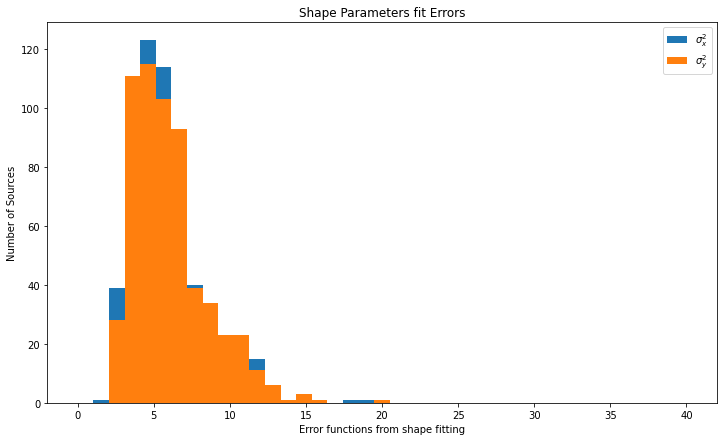

In [27]:
binlist=np.linspace(0,40,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat25snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat25snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [28]:
print('Covar X^2 mean: ', np.mean(mcat25snrcut['covar_sigx2']), '  stdev: ',np.std(mcat25snrcut['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mcat25snrcut['covar_sigy2']), '  stdev: ',np.std(mcat25snrcut['covar_sigy2']))

Covar X^2 mean:  5.799695142703025   stdev:  2.3968986946230033
Covar Y^2 mean:  6.021533053194711   stdev:  2.4865499265968816


In [29]:
#add quality flags to table
sigXmean=np.mean(mcat25snrcut['covar_sigx2'])
sigXstd=np.std(mcat25snrcut['covar_sigx2'])

sigYmean=np.mean(mcat25snrcut['covar_sigy2'])
sigYstd=np.std(mcat25snrcut['covar_sigy2'])

sigXidx=mcat25snrcut['covar_sigx2']>sigXmean+sigXstd
sigYidx=mcat25snrcut['covar_sigy2']>sigYmean+sigYstd

mcat25snrcut['shape_qflag'][sigXidx]=mcat25snrcut['shape_qflag'][sigXidx]+10
mcat25snrcut['shape_qflag'][sigYidx]=mcat25snrcut['shape_qflag'][sigYidx]+20

In [30]:
#number of sources that are well fit by shape fitting
np.count_nonzero(mcat25snrcut['shape_qflag']==0)

405

In [31]:
#number of sources that may not be well fit by the shape fitting
np.count_nonzero(mcat25snrcut['shape_qflag']>0)

187

In [32]:
mcat25snrcut

type,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_4.25pix,aperture_sum_err_4.25pix,aperture_sum_4.5pix,aperture_sum_err_4.5pix,aperture_sum_4.75pix,aperture_sum_err_4.75pix,aperture_sum_5.0pix,aperture_sum_err_5.0pix,aperture_sum_5.25pix,aperture_sum_err_5.25pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_4.25pix,aper_snr_4.25pix,aper_area_4.25pix,aper_sum_bkgsub_4.5pix,aper_snr_4.5pix,aper_area_4.5pix,aper_sum_bkgsub_4.75pix,aper_snr_4.75pix,aper_area_4.75pix,aper_sum_bkgsub_5.0pix,aper_snr_5.0pix,aper_area_5.0pix,aper_sum_bkgsub_5.25pix,aper_snr_5.25pix,aper_area_5.25pix,aper_sum_bkgsub_5.5pix,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19,int64,int32,int32
10,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.4236458480866823,0.10047859269606844,1.5466724294218617,0.10682069261019145,1.6750884713269265,0.11316535920513267,1.811050718384554,0.11953170198323691,1.9531973783819776,0.1259296609481708,2.1006656962556454,0.13241835165576693,2.2508335266315496,0.13897037508002757,3.8682682544679565,0.20602930127861335,4.96666312214726,0.259997705122562,5.481791418260418,0.31385377241813783,842.3886568673647,-0.0004654688610713117,-0.0012500817765666544,0.009320970097764732,262.2360534667969,205.75838464830025,1.4481524536298975,17.15805958065859,52.649291054210295,1.5743380895858818,18.902379349781103,59.4361137291671,1.7061046439675582,20.75629293688845,66.6342589904849,1.8456088613576036,22.761832113490314,74.24372683816375,1.9914889495432515,24.89419663722413,82.26451727220358,2.14288215346095,27.13750399429203,90.69663029260447,2.297166327736691,29.44128686435674,99.54006589936637,3.9662946766408176,55.11135086679856,210.59716421684118,5.1198294067923555,72.10873074592747,329.0580690888143,5.702350868149355,77.77123090967218,473.84361948789274,Field49,25,6.7456997274677555,7.975597084552329,6.581135564871462,3.2529737500683717,2.24486693578359,-81.07403059593263,1.449071968683477,5.172855864516933,10.448409913491359,1.4959128022772794,-0.024519865598240723 .. 0.004305923092190833,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.3464-0.0829,0,0,20
10,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.914611742490516,0.08565943133769197,2.09599303701002,0.09125818516820391,2.2658869049688377,0.09690035335625888,2.4363750292144504,0.10257197890324246,2.6099130502012837,0.10832554482748215,2.7856322410183307,0.11412600802904477,2.9671053266403287,0.11993951266956053,4.671164651453947,0.179963538821

In [33]:
#generate ds9 files for sources that might be too distant to be correct. 
distidx0a=mcat25snrcut['fit_dist']<=2.0
distidx0b=mcat25snrcut['fit_dist']<=4.0
distidx1=mcat25snrcut['fit_dist']>4.0
distidx2=mcat25snrcut['fit_dist']>7.0

sourcesbest=mcat25snrcut[distidx0a]
sourcesgood=mcat25snrcut[distidx0b]
sourcesbad=mcat25snrcut[distidx1]
sourcesreallybad=mcat25snrcut[distidx2]

makeDS9file('mastercat_25m_shapepar_in2pix.reg', sourcesbest, r, color='green')
makeDS9file('mastercat_25m_shapepar_in4pix.reg', sourcesgood, r, color='yellow')
makeDS9file('mastercat_25m_shapepar_in7pix.reg', sourcesbad, r, color='red')
makeDS9file('mastercat_25m_shapepar_out7pix.reg', sourcesreallybad, r, color='magenta')

In [34]:
makeDS9file('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green')

In [35]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat25snrcut.write('masterCat_25um_Step3.fits',overwrite=True)

In [37]:
# print different source types by discovery stream
#mcat25snrcut['type'].tolist().count(10)
#mcat25snrcut['type'].tolist().count(110)
#mcat25snrcut['type'].tolist().count(120)
#mcat25snrcut['type'].tolist().count(210)
#mcat25snrcut['type'].tolist().count(220)
#mcat25snrcut['type'].tolist().count(310)
#mcat25snrcut['type'].tolist().count(320)
#mcat25snrcut['type'].tolist().count(3)

## Now for 37 um data

In [38]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#add names to mastercat
mastercat37=createNames(mastercat37)

#print the master catalog
mastercat37

type,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_4.25pix,aperture_sum_err_4.25pix,aperture_sum_4.5pix,aperture_sum_err_4.5pix,aperture_sum_4.75pix,aperture_sum_err_4.75pix,aperture_sum_5.0pix,aperture_sum_err_5.0pix,aperture_sum_5.25pix,aperture_sum_err_5.25pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_4.25pix,aper_snr_4.25pix,aper_area_4.25pix,aper_sum_bkgsub_4.5pix,aper_snr_4.5pix,aper_area_4.5pix,aper_sum_bkgsub_4.75pix,aper_snr_4.75pix,aper_area_4.75pix,aper_sum_bkgsub_5.0pix,aper_snr_5.0pix,aper_area_5.0pix,aper_sum_bkgsub_5.25pix,aper_snr_5.25pix,aper_area_5.25pix,aper_sum_bkgsub_5.5pix,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,"cutouts [25,25]",RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,str19
10,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",3.003760327746862,0.14541289836027693,3.3350911006055854,0.15450551117949876,3.6759241090181893,0.16360782186511172,4.025381980909588,0.17269633935312764,4.387698153641651,0.1817706280425396,4.753600402579483,0.1908181185485436,5.123533538584693,0.19983777651406937,9.012481685779882,0.28996957415328034,12.239547458194826,0.36266240680479744,15.383102521386029,0.43540631530641877,842.3886173246749,0.005622031711539766,0.008471183269574802,0.013955006665011,336.5355529785156,271.4465937975625,2.707764357744396,35.04768898504187,52.64928858279218,3.000939400094989,39.56484141180995,59.43611093916773,3.3013042094838183,44.22485716927925,66.63425586259635,3.6079814138357977,49.009328999221296,74.24372335307804,3.9252044505127976,53.996931408592765,82.26451341061278,4.243701094879922,59.01115855367395,90.69662603520058,4.563916157798781,64.05937112153697,99.54006122684149,7.828497805770017,115.7189276622947,210.59715433116872,10.389572645679412,156.05494971039607,329.0580536424511,12.719138791363836,192.01020614754427,473.8435972451295,Field49,37,8.41351452922998,5.051601869793316,5.9143730259950615,2.7441092381983805,2.2552524197669332,-70.2869145397762,1.2167636820369614,5.364234255069091,7.252064732961212,2.3998739544318672,-0.0081538253006944 .. 0.015978603816286404,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.3482-0.0824
220,204.5406252159332,92.06476523812742,"266.1042949324219,-29.53248553795637",0.11960443712265664,0.1355360534512207,0.11335386256770036,0.14400653921907317,0.12359952271629106,0.152477347855417,0.14998452936196965,0.16094763755733577,0.19044340891734463,0.16941756175060427,0.25724041190547964,0.17788737471305816,0.33151611972896794,0.1863575161942756,1.0610434036926462,0.2710577581947908,1.5306242779065902,0.33878745705292934,2.480834550842599,0.406

In [39]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [40]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_37um_labelID.reg', mastercat37, r, color='yellow', labelon=True, label="id")
makeDS9file('mastercatComb_37um_label4pixSNR.reg', mastercat37, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [41]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat37))

mastercat37=remove_duplicates(mastercat37, 5.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 864
number of likely duplicates:  309
Number of sources with duplicates removed 690


In [42]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [43]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', labelon=True, label="id")

### Quality Flags and Cuts

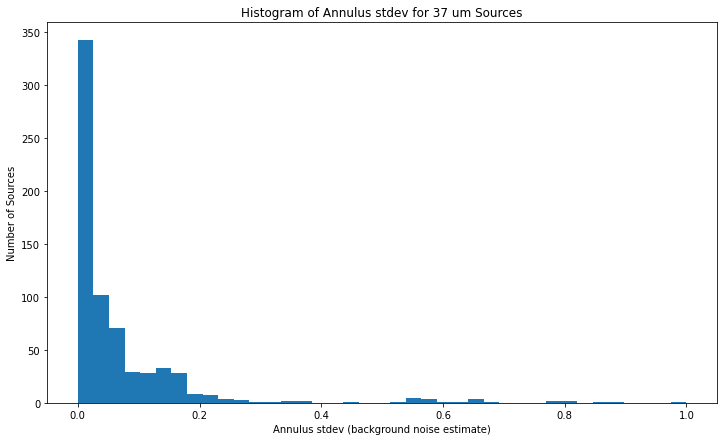

In [44]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 37 um Sources')
plt.hist(mastercat37['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [45]:
#add quality flags for background noise
bkgmean=np.mean(mastercat37['ann_bkg_std'])
bkgstd=np.std(mastercat37['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat37['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat37['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat37['ann_bkg_std']>bkgmean+3*bkgstd


mastercat37['bkg_qflag']=0
mastercat37['bkg_qflag'][bkgstd1sig]=1
mastercat37['bkg_qflag'][bkgstd2sig]=2
mastercat37['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.0830555929843329 , standard deviation of noise measurements:  0.16875128216130972


In [46]:
print('Central distance fit mean: ', np.mean(mastercat37['fit_dist']), '  stdev: ',np.std(mastercat37['fit_dist']))

Central distance fit mean:  1.7968008784967289   stdev:  1.3050526218361298


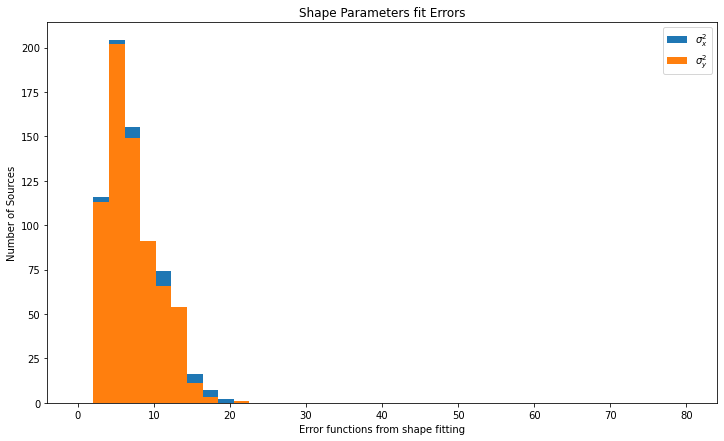

In [47]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat37['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mastercat37['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [48]:
print('Covar X^2 mean: ', np.mean(mastercat37['covar_sigx2']), '  stdev: ',np.std(mastercat37['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mastercat37['covar_sigy2']), '  stdev: ',np.std(mastercat37['covar_sigy2']))

Covar X^2 mean:  7.1574683234773255   stdev:  3.331885333943074
Covar Y^2 mean:  7.268509844133906   stdev:  3.21946913381235


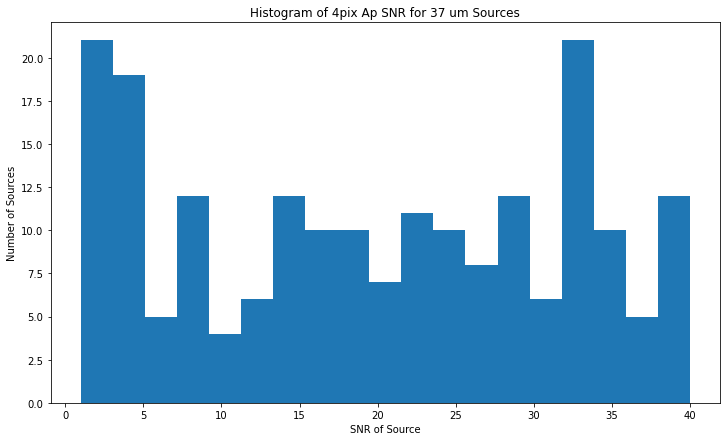

In [49]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [50]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_4pix']>=3.0 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  552


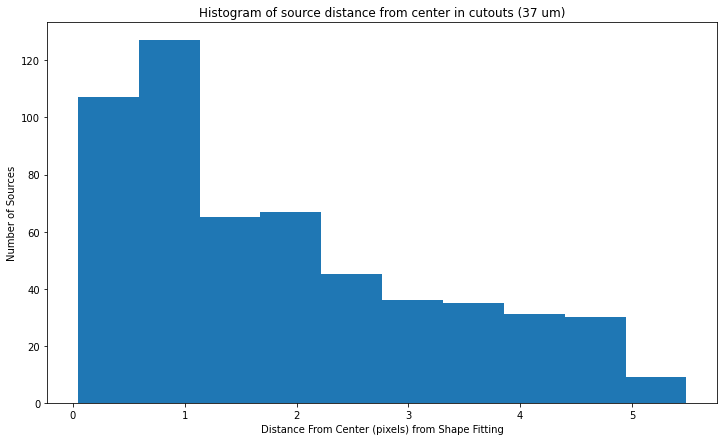

In [51]:
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (37 um)')
plt.hist(mcat37snrcut['fit_dist'])#,bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [52]:
print('Central distance fit mean: ', np.mean(mcat37snrcut['fit_dist']), '  stdev: ',np.std(mcat37snrcut['fit_dist']))

Central distance fit mean:  1.8580262812088617   stdev:  1.383004714831753


In [53]:
#apply quality flags to table
Distmean=np.mean(mcat37snrcut['fit_dist'])
Diststd=np.std(mcat37snrcut['fit_dist'])

distidx1=mcat37snrcut['fit_dist']>4.0
distidx2=mcat37snrcut['fit_dist']>7.0

mcat37snrcut['shape_qflag']=0

mcat37snrcut['shape_qflag'][distidx1]=1
mcat37snrcut['shape_qflag'][distidx1]=mcat37snrcut['shape_qflag'][distidx1]+1

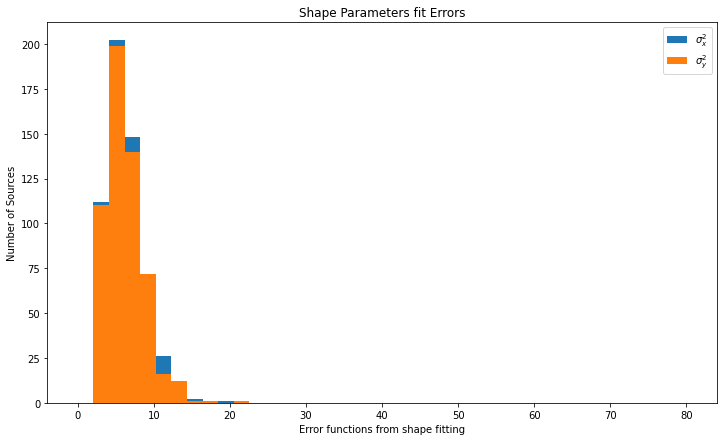

In [54]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat37snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat37snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [55]:
print('Covar X^2 mean: ', np.mean(mcat37snrcut['covar_sigx2']), '  stdev: ',np.std(mcat37snrcut['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mcat37snrcut['covar_sigy2']), '  stdev: ',np.std(mcat37snrcut['covar_sigy2']))

Covar X^2 mean:  6.074572078884504   stdev:  2.4241677832953155
Covar Y^2 mean:  6.239851601468082   stdev:  2.4438409945773176


In [56]:
#add quality flags to table
sigXmean=np.mean(mcat37snrcut['covar_sigx2'])
sigXstd=np.std(mcat37snrcut['covar_sigx2'])

sigYmean=np.mean(mcat37snrcut['covar_sigy2'])
sigYstd=np.std(mcat37snrcut['covar_sigy2'])

sigXidx=mcat37snrcut['covar_sigx2']>sigXmean+sigXstd
sigYidx=mcat37snrcut['covar_sigy2']>sigYmean+sigYstd

mcat37snrcut['shape_qflag'][sigXidx]=mcat37snrcut['shape_qflag'][sigXidx]+10
mcat37snrcut['shape_qflag'][sigYidx]=mcat37snrcut['shape_qflag'][sigYidx]+20

In [57]:
#number of sources that are well fit by shape fitting
np.count_nonzero(mcat37snrcut['shape_qflag']==0)

364

In [58]:
#number of sources that may not be well fit by the shape fitting
np.count_nonzero(mcat37snrcut['shape_qflag']>0)

188

In [59]:
#more cuts to consider?

In [60]:
makeDS9file('mastercatComb_4pixSNRselect_37m_NoLabel.reg', mcat37snrcut, r, color='green')

In [61]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat37snrcut.write('masterCat_37um_Step3.fits',overwrite=True)

## Crossmatch the 25 and 37 um catalogs

In [314]:
#get source coordinates from both tables
sources25=mcat25snrcut['sky_centroid']
sources37=mcat37snrcut['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 5*u.arcsec) #use larger search radius?
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  386


In [315]:
matched25=mcat25snrcut[rdx]
matched37=mcat37snrcut[idx]

In [316]:
notrdx=findNOTindex(mcat25snrcut,rdx)
only25=mcat25snrcut[notrdx]

notidx=findNOTindex(mcat37snrcut,idx)
only37=mcat37snrcut[notidx]

In [317]:
t1=Table()
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um Flux (Jy)']=matched25['aper_sum_bkgsub_4pix']
t1['fwhm25']=matched25['fwhm']
t1['25um SNR']=matched25['aper_snr_4pix']
t1['37um Flux (Jy)']=matched37['aper_sum_bkgsub_4pix']
t1['37um SNR']=matched37['aper_snr_4pix']
t1['fwhm37']=matched37['fwhm']


t2=Table()
t2['RA(J2000)']=only25['RA(J2000)']
t2['DEC(J2000)']=only25['DEC(J2000)']
t2['25um Flux (Jy)']=only25['aper_sum_bkgsub_4pix']
t2['25um SNR']=only25['aper_snr_4pix']
t2['fwhm25']=only25['fwhm']
t2['37um Flux (Jy)']=-1
t2['37um SNR']=-1
t2['fwhm37']=-1


t3=Table()
t3['RA(J2000)']=only37['RA(J2000)']
t3['DEC(J2000)']=only37['DEC(J2000)']
t3['25um Flux (Jy)']=-1
t3['25um SNR']=-1
t3['fwhm25']=-1
t3['37um Flux (Jy)']=only37['aper_sum_bkgsub_4pix']
t3['37um SNR']=only37['aper_snr_4pix']
t3['fwhm37']=only37['fwhm']

In [318]:
mastercat=vstack((t1,t2,t3))

In [319]:
#change format of columns to save fewer decimal places
for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

#display catalog
mastercat

RA(J2000),DEC(J2000),25um Flux (Jy),fwhm25,25um SNR,37um Flux (Jy),37um SNR,fwhm37
deg,deg,,pix,,,,pix
float64,float64,float64,float64,float64,float64,float64,float64
266.09495036354866,-29.53536811998432,1.941,8.994,28.41,2.708,35.05,8.997
266.0976520367033,-29.5169558758474,1.943,8.27,31.23,2.627,33.96,8.868
266.1066587461282,-29.513297870753597,3.794,8.31,65.03,4.964,62.91,8.627
266.11699223318425,-29.51585973844053,2.346,8.842,33.54,4.683,50.57,8.937
266.12312364597364,-29.517588948087333,1.734,9.55,25.34,2.963,39.42,10.62
266.04694161813114,-29.444187095468855,2.906,7.728,48.65,5.837,97.99,7.604
266.02006908793686,-29.42252156100146,2.767,7.983,43.23,3.711,51.45,9.216
266.02006908793686,-29.42252156100146,2.767,7.983,43.23,2.528,24.06,8.926


In [321]:
#write out final catalog
mastercat.write('masterCat_step3_combined.fits',overwrite=True)

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [39]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_25392/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


number of likely duplicates:  294
Number of 25 um Seg Catalog Sources after SNR cut:  858


In [40]:
Segcat25snr

old_id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int32
1,185.74025305952063,45.29468593234474,-0.0010024959751888693,-0.0004956385032757274,-0.05005948883084846,101.0,2.6243450015424092,2.1592520002946807,6.6485615155907,0.14612593264096238,-0.01593585441761772,0.21355446379362664,0.5683636138426366,0.1772225073206377,1.2153954245193501,5.658813338648118,9.452813107528392,0.26268936835739903,2.275454410029209,5.635387378601118,0.10810196399688721,-0.0004975240031514727,-0.0005376331807221336,0.00013432667608972187,16.156001325545247,185.7402530596197,45.2946859322694,"266.3255679286236,-29.0777961489855",4.223261726128053,0.07965694794375933,6.990669465142625,0.13954518125803658,9.274056937915002,0.238326336657559,842.3889672608536,0.00015622811410386216,0.00040810074823285295,0.005793276622484106,419.3362724757975,336.2819897809317,4.215036423646986,75.11780662752693,52.64931045380335,6.96547947629436,123.6823749899232,161.2385132647728,9.200029215585404,159.73011029162714,473.84379408423024,FieldA,25,4.378306921607122,3.8199525587441663,5.1955358339515545,2.2621740636932857,2.149057712389039,11.862892326351194,266.3255679286236,-29.0777961489855,"266.3255679286236,-29.0777961489855",1,0
2,99.33997412427225,135.7560428642921,0.000645686407520613,0.01972296132447175,3.431795270458084,174.0,3.8835755737063407,3.2426723319262165,-1.7704318600475983,0.06633099263366786,0.0017786637010446392,0.09507543463733634,0.5502942012990037,0.1650291669664793,1.1976466248131257,8.42438032703874,--,--,nan,5.714359056859989,0.11486293375492096,0.019715966455985303,0.01957748140953601,0.0043672587653352255,6.10972394850931,99.33997412423895,135.75604286425096,"266.3466547631106,-29.058496515013818",2.2444751769657416,0.06317449923777498,5.263501701641234,0.11057385187481032,8.179289331002943,0.18959596849336177,842.3889672608536,-0.0022032085635257017,-0.0024315801082415126,0.006543116118794441,477.7574157714844,476.9713757719391,2.3604725886212847,38.64366558564773,52.64931045380335,5.618743774836334,96.69975751476773,161.2385132647728,9.223266035902828,157.8522858399414,473.84379408423024,FieldA,25,3.832897264201368,4.41238741642627,5.783185493264922,2.4629032764829675,2.44886216866295,-45.987069195414584,266.3466547631106,-29.058496515013818,"266.3466547631106,-29.058496515013818",2,0
3,83.94487721758777,159.5619761735801,0.0009578778421280461,0.03018293132272653,2.8371955443362937,94.0,2.9415442293194145,2.491499368532639,85.1490718882491,0.16076812412716185,-0.007671521450482014,0.11589662823547614,0.5315867109270886,0.15299612234316196,1.1806321392133556,6.418829011

In [41]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_25392/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


number of likely duplicates:  282
Number of 37 um Seg Catalog Sources after SNR cut:  920


In [42]:
Segcat37snr

old_id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int32
1,165.88124869656778,135.1457600413451,0.105157953693618,0.08381862214796677,0.6705489771837342,8.0,0.8769722412230371,0.6688080918264174,43.894949188395,1.7498989131658533,-0.9346646218817445,1.7859701379371873,0.6468312744319636,0.2373668624976215,1.3112464576021408,1.836446066762363,3.0502143518220093,0.218849915392413,3.5576433313609304,0.3180231434827696,0.05132055655121803,0.08380100852482836,0.08372312982837603,0.0017530802984467436,1.2440902422001605,165.88124869667803,135.14576004139107,"266.32998730132323,-29.06066444114748",1.4361474202736453,0.13156885091446782,3.4240688268525985,0.2301722297471936,6.334599409822843,0.39444305527428686,842.3886494273573,-0.0004895834732235229,-0.0014007875371557087,0.015934638470782567,400.12127685546875,399.28152922907714,1.461923642823065,11.841245627924435,52.649290589209805,3.503008508410197,35.623862346703916,161.23845242945507,6.566585412767622,70.69985509181079,473.8436153028882,FieldA,37,4.6615991348491255,4.509769738878789,5.350586354743857,2.3200332857300094,2.223306826488856,47.27429070714086,266.32998730132323,-29.06066444114748,"266.32998730132323,-29.06066444114748",1,0
2,167.721005456061,139.46752245357496,0.10689638267581611,0.09481086211696702,0.6636760348187691,7.0,1.2340198435091818,0.5847190899471192,-21.821246697740367,0.970077048804135,1.5653987412335955,2.61146835817579,0.8806148239969739,0.5261671900798988,2.1104490424979696,2.273774403851281,3.4409512080472973,0.24859120479955898,3.6420654056456057,0.2440112566841834,0.04795633628964424,0.09331031030341473,0.09330699734645656,0.002666071464332059,0.9453907304634207,167.72100545600614,139.46752245360557,"266.3295382816666,-29.05974246988601",1.5821418218562586,0.13160807260993931,3.6855860075505813,0.23030600062649667,5.754407922891304,0.39480453920049835,842.3886494273573,-0.0003286288233462775,-0.0012227842082075061,0.01675698505552631,400.12127685546875,399.59329539155095,1.599443896272607,13.359639770918713,52.649290589209805,3.738573610450648,38.38912912650552,161.23845242945507,5.910126592638439,57.47936235547718,473.8436153028882,FieldA,37,4.172936348945814,3.6415464483904443,5.739674384677733,2.550069670800815,2.3192954259942944,58.439418286752016,266.3295382816666,-29.05974246988601,"266.3295382816666,-29.05974246988601",2,0
3,67.73793200190819,155.70307950024414,-0.004177105834915287,0.05753259209647462,0.2876629604823731,5.0,1.1947068696746086,0.28650901315579624,-34.92444736022005,4.463697121268363,10.778709370165084,8.41904981103734,0.9708185263629986,0.760184677573813

## testing...

In [66]:
np.max(Segcat25['fwhm'])

6.0680694089549565

In [67]:
np.min(Segcat25['fwhm'])

3.0486507818268596

In [68]:
np.mean(Segcat25['fwhm'])

5.457743928773992

In [69]:
np.std(Segcat25['fwhm'])

0.42717443772804187

In [70]:
np.mean(Segcat25['fwhm_seg'])

4.871949935807235

In [71]:
np.std(Segcat25['fwhm_seg'])

2.880269379660212

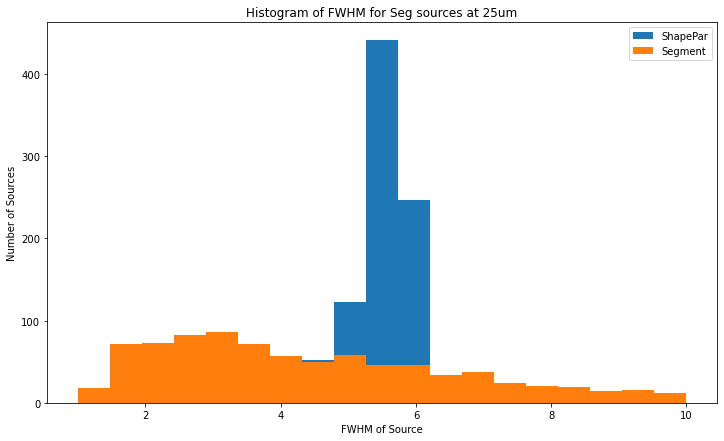

In [45]:
#now lets look at SNR distrobution
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for Seg sources at 25um')
plt.hist(Segcat25['fwhm'],bins=binlist,label='ShapePar')
plt.hist(Segcat25['fwhm_seg'],bins=binlist,label='Segment')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [46]:
xmatch=mcat25snrcut['type']=='C'
segonly=mcat25snrcut['type']=='S'
daoonly=mcat25snrcut['type']=='D'

In [47]:
xmatch25=mcat25snrcut[xmatch]
seg25=mcat25snrcut[segonly]
dao25=mcat25snrcut[daoonly]

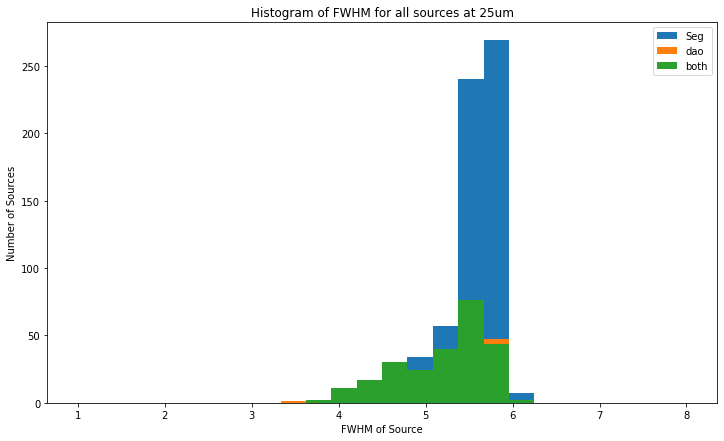

In [48]:
#now lets look at SNR distrobution
binlist=np.linspace(1,8,25)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for all sources at 25um')
plt.hist(seg25['fwhm'],bins=binlist,label='Seg')
plt.hist(dao25['fwhm'],bins=binlist,label='dao')
plt.hist(xmatch25['fwhm'],bins=binlist,label='both')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()